Architectures to try:
- BERT (RoBERTa, etc.)
- SentenceBert
- Universal Sentence Encoder
- ELECTRA

https://huggingface.co/emilyalsentzer/Bio_ClinicalBERT  
https://huggingface.co/medicalai/ClinicalBERT

https://huggingface.co/nlpie

TODO: https://huggingface.co/datasets/Elfsong/ClinicalDataset

In [1]:
from typing import Union

from transformers import AutoModel, AutoTokenizer
import torch
from tqdm.auto import tqdm

from mrq.models import EmbedModel

device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)

cpu


In [2]:
models_to_test = [
    "emilyalsentzer/Bio_ClinicalBERT",
    "medicalai/ClinicalBERT",
    "pritamdeka/S-Biomed-Roberta-snli-multinli-stsb",
    # "menadsa/S-Bio_ClinicalBERT", broken???
    "menadsa/S-BioELECTRA",
    "TimKond/S-BioLinkBert-MedQuAD",
    "TimKond/S-PubMedBert-MedQuAD",
    "kamalkraj/bioelectra-base-discriminator-pubmed"
]

In [3]:
emb_model = EmbedModel(models_to_test[-3], device=device)

# small smoke test
a = emb_model("text")
assert a.square().sum().sqrt() == 1

print(emb_model("tumor in the chest") @ emb_model("lungs cancer").T)

tensor([[0.9814]])


## Evaluation of embeddings

In [4]:
from mrq.data import load_data

sample_size = 200
seed = 1337

data = load_data("medmcqa", sample_size=sample_size, seed=seed)
data1 = load_data("AnonymousSub/MedQuAD_47441_Question_Answer_Pairs", sample_size=sample_size, seed=seed)

Using custom data configuration default
Found cached dataset medmcqa (/Users/Vasilii_Salikov/.cache/huggingface/datasets/medmcqa/default/1.1.0/f2fdfa9ccfbf9d148c0639e6afe3379f3c7e95c4d52d5e68ec1156e5004bd880)
Using custom data configuration AnonymousSub--MedQuAD_47441_Question_Answer_Pairs-5625072dd394af39
Found cached dataset parquet (/Users/Vasilii_Salikov/.cache/huggingface/datasets/AnonymousSub___parquet/AnonymousSub--MedQuAD_47441_Question_Answer_Pairs-5625072dd394af39/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


'MODEL: emilyalsentzer/Bio_ClinicalBERT'

Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


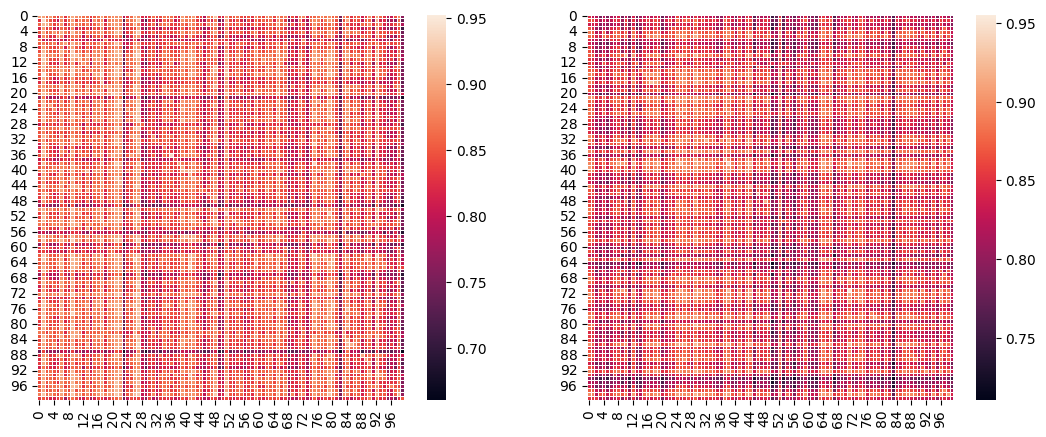

'----------------------------------------------------------------------------------------------------'

'MODEL: medicalai/ClinicalBERT'

Some weights of the model checkpoint at medicalai/ClinicalBERT were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


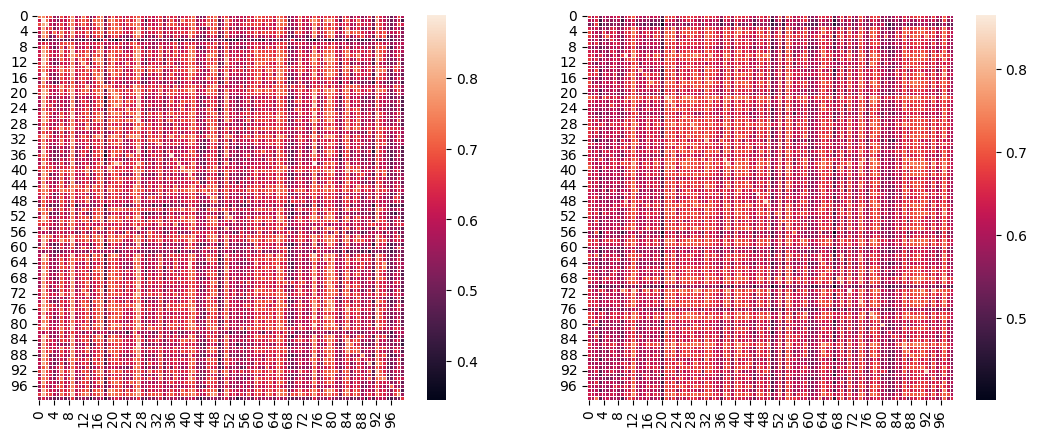

'----------------------------------------------------------------------------------------------------'

'MODEL: pritamdeka/S-Biomed-Roberta-snli-multinli-stsb'

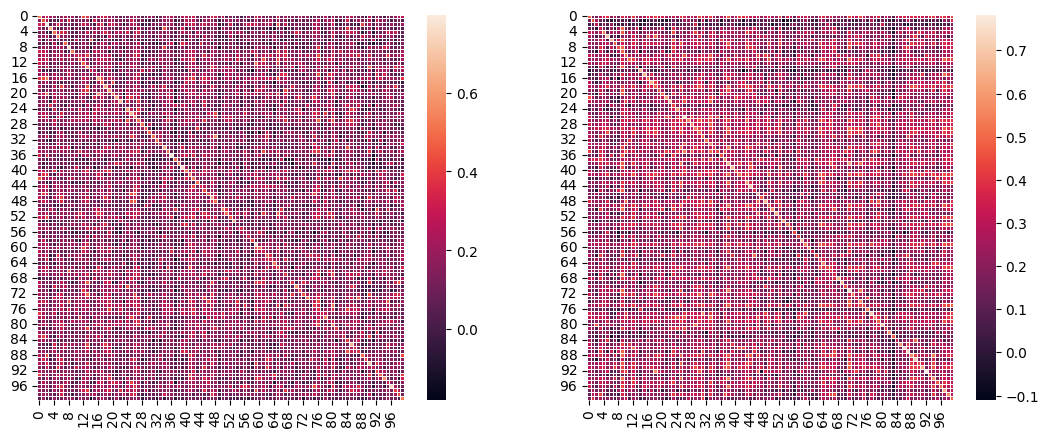

'----------------------------------------------------------------------------------------------------'

'MODEL: menadsa/S-BioELECTRA'

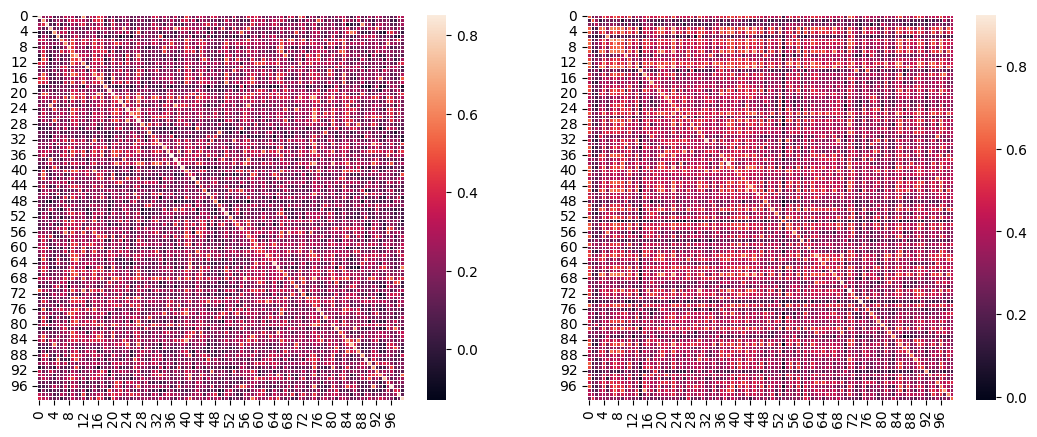

'----------------------------------------------------------------------------------------------------'

'MODEL: TimKond/S-BioLinkBert-MedQuAD'

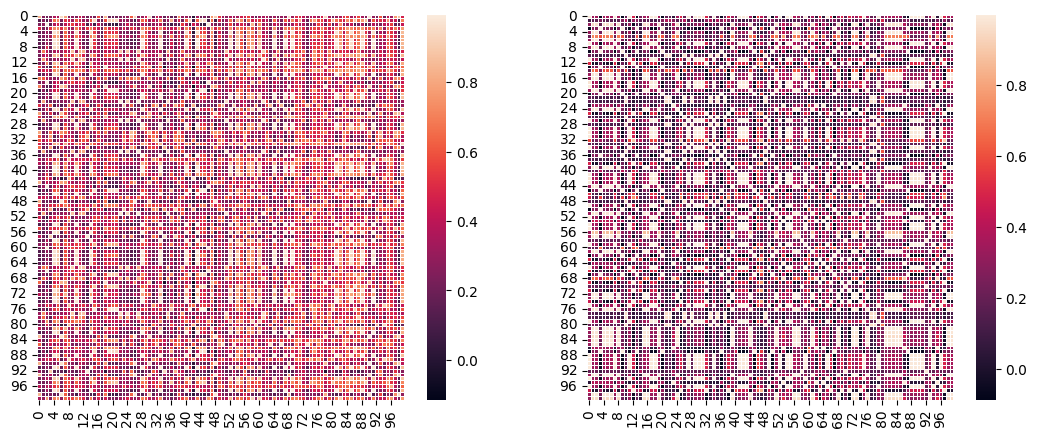

'----------------------------------------------------------------------------------------------------'

'MODEL: TimKond/S-PubMedBert-MedQuAD'

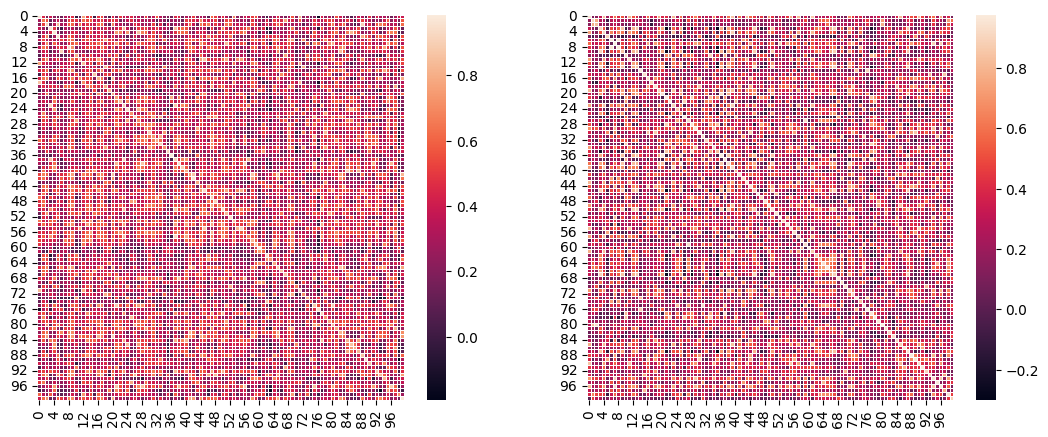

'----------------------------------------------------------------------------------------------------'

'MODEL: kamalkraj/bioelectra-base-discriminator-pubmed'

Some weights of the model checkpoint at kamalkraj/bioelectra-base-discriminator-pubmed were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


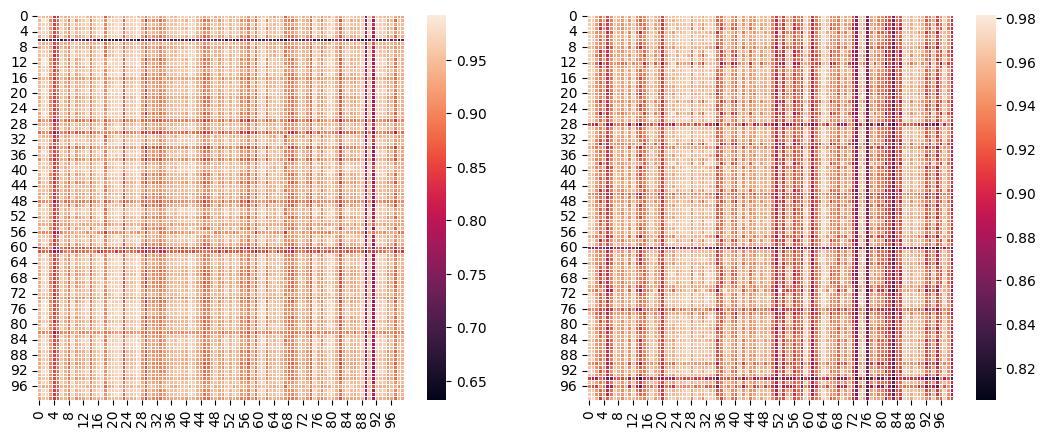

'----------------------------------------------------------------------------------------------------'

In [12]:
import seaborn as sns
import matplotlib.pylab as plt

from mrq.data import AnswerDB


def test_model_plot(model_name, datalist, sub_sample_to_show=100, batch_to_process=5):
    display("MODEL: " + model_name)
    emb_model = EmbedModel(model_name=model_name, device=device)
    fig, axs = plt.subplots(1, len(datalist), figsize=(13, 5))
    for i, d in enumerate(datalist):
        ans_embedded = AnswerDB(d["A"][:sub_sample_to_show]).encode(
            emb_model, tqdm_flag=True, batch_len=batch_to_process
        ).embedded
        questions_embedded = AnswerDB(d["Q"][:sub_sample_to_show]).encode(
            emb_model, tqdm_flag=True, batch_len=batch_to_process
        ).embedded
        a = ans_embedded.cpu() @ questions_embedded.cpu().T

        sns.heatmap(a, linewidth=0.5, ax=axs[i])
    plt.show()
    display("-" * 100)

for m in models_to_test:
    test_model_plot(m, [data, data1])

In [ ]:
models_to_test = [
    "emilyalsentzer/Bio_ClinicalBERT", # hmmmmm, ok?
    "medicalai/ClinicalBERT", # a bit better than Bio_ClinicalBERT
    "pritamdeka/S-Biomed-Roberta-snli-multinli-stsb", # nice
    # "menadsa/S-Bio_ClinicalBERT", broken???
    "menadsa/S-BioELECTRA", # nice
    "TimKond/S-BioLinkBert-MedQuAD", # medquad only?
    "TimKond/S-PubMedBert-MedQuAD", # nice
    "kamalkraj/bioelectra-base-discriminator-pubmed" # very very meh
]